<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss,
                             precision_recall_fscore_support, classification_report, 
                             accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [5]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [6]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:33<00:00, 35.52it/s]


In [7]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [8]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [9]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


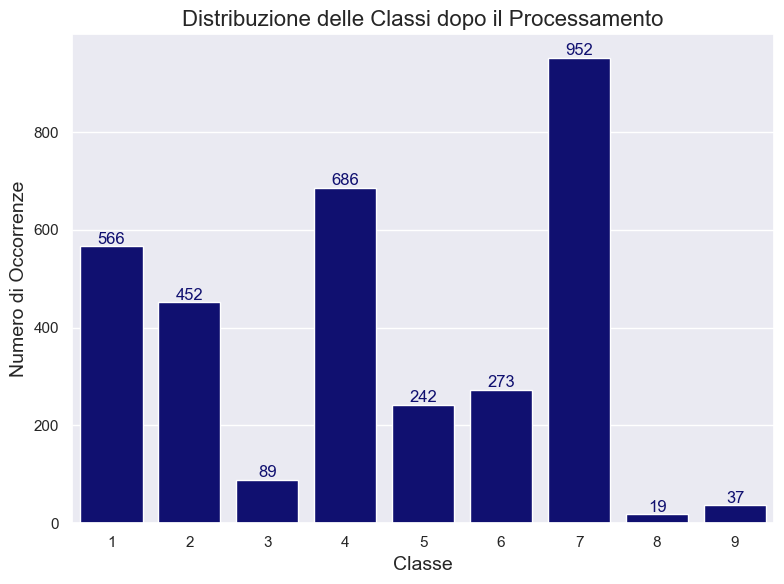

In [10]:
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, color='navy')  # Imposta un colore uniforme per le barre

# Titolo e etichette
plt.title('Distribuzione delle Classi dopo il Processamento', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Aggiungere il numero sopra ogni barra con lo stesso colore della barra
for p in ax.patches:
    height = int(p.get_height())  # Otteniamo l'altezza della barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                xytext=(0, 5), textcoords='offset points')

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


In [17]:
df['Class'].value_counts()

Class
7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: count, dtype: int64

<h2> MODELLAZIONE</h2>

In [82]:
# Separazione delle feature e della target

X_text = df['text']
X_gene_variation = df[['Gene', 'Variation']]
y = df['Class']

In [94]:
# Step 1: Encoding per Gene e Variation
X_gene_variation_encoded = pd.get_dummies(X_gene_variation, columns=['Gene', 'Variation'])

# Step 2: Vettorizzazione del testo
tfidf = TfidfVectorizer(max_features=3000)
X_text_vectorized = tfidf.fit_transform(X_text).toarray()

# Step 3: Unione delle feature
X = np.hstack([X_text_vectorized, X_gene_variation_encoded.values])

# Step 4: Applicare RandomOverSampler e RandomUnderSampler prima della divisione

# 4a. Creazione di RandomOverSampler per sovracampionare le classi minoritarie
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# 4b. Creazione di RandomUnderSampler per sottocampionare le classi maggioritarie
undersampler = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = undersampler.fit_resample(X_oversampled, y_oversampled)

# Verifica della distribuzione dopo il bilanciamento
print("Distribuzione delle classi dopo bilanciamento:")
print(Counter(y_balanced))



Distribuzione delle classi dopo bilanciamento:
Counter({1: 952, 2: 952, 3: 952, 4: 952, 5: 952, 6: 952, 7: 952, 8: 952, 9: 952})


In [95]:
# Step 5: Divisione train/test con il dataset bilanciato
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Verifica la distribuzione delle classi nel train e nel test set
print("Distribuzione delle classi nel train set dopo bilanciamento:")
print(Counter(y_train))
print("Distribuzione delle classi nel test set dopo bilanciamento:")
print(Counter(y_test))

Distribuzione delle classi nel train set dopo bilanciamento:
Counter({1: 762, 2: 762, 6: 762, 8: 762, 9: 762, 7: 761, 3: 761, 5: 761, 4: 761})
Distribuzione delle classi nel test set dopo bilanciamento:
Counter({5: 191, 4: 191, 3: 191, 7: 191, 1: 190, 6: 190, 8: 190, 2: 190, 9: 190})


In [96]:
class_weights = {1: 5, 2: 4, 3: 6, 4: 1, 5: 1, 6: 1, 7: 1, 8: 8, 9: 10}

# Addestramento del modello RF
rf = RandomForestClassifier(random_state=0 ,class_weight='balanced')

# Ricerca degli iperparametri con GridSearchCV
param_grid = {
    'n_estimators': [100,200,400],
    'max_depth': [10, 20, 30],
}


In [97]:
# GridSearch con il dataset bilanciato
grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=3,scoring='f1_weighted',verbose=1,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Miglior modello
best_rf = grid_search.best_estimator_
print("Migliori Iperparametri trovati con GridSearchCV:")
print(grid_search.best_params_)


# Valutazione sul test set
y_pred = best_rf.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


print("\nReport di Classificazione:")
print(classification_rep)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Migliori Iperparametri trovati con GridSearchCV:
{'max_depth': 30, 'n_estimators': 400}

Report di Classificazione:
              precision    recall  f1-score   support

           1       0.88      0.96      0.92       190
           2       0.91      0.86      0.88       190
           3       0.93      1.00      0.96       191
           4       0.96      0.83      0.89       191
           5       0.96      0.97      0.97       191
           6       0.98      0.99      0.99       190
           7       0.83      0.82      0.83       191
           8       1.00      1.00      1.00       190
           9       0.99      1.00      1.00       190

    accuracy                           0.94      1714
   macro avg       0.94      0.94      0.94      1714
weighted avg       0.94      0.94      0.94      1714



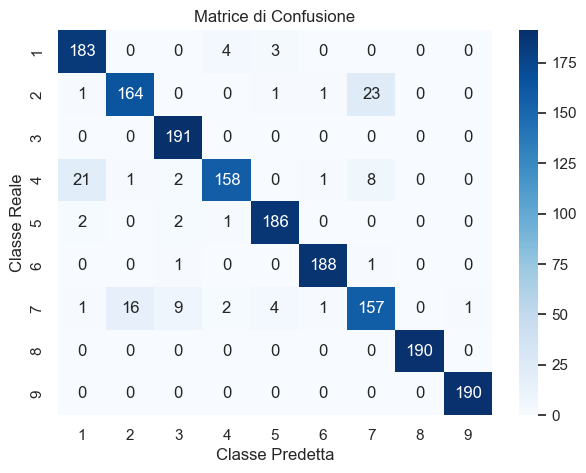

In [98]:
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title("Matrice di Confusione")
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Reale")
plt.show()